In [3]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [171]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import divergence
from pinns.krr import krr, rbf
from pinns.elm import elm
from pinns.pde import poisson_dirichlet_qp_mc, poisson_dirichlet_ecqp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [241]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)

x_sup = x_dom[:2**8]
x_bnd_sum = x_bnd[:2**6]

In [242]:
def plot_result(sol, ax):
    plt.sca(ax)
    N = 100
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: abs(model(x) - norm(x, axis=-1) + 1), ax2)
    ax2.set_title("abs error")


In [243]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W_elm = pi * (weights[:, :3] * 2 - 1)
b_elm = pi * (weights[:, 3] * 2 - 1)
params0 = zeros_like(b_elm)


def normalize(x):
    return x / norm(x, axis=-1, keepdims=True)

m_const = lambda x: array([0., 0., 1.])

def m_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    mx = - y / r * sqrt(1 - exp(-4*k))
    my = x / r * sqrt(1 - exp(-4*k))
    mz = exp(-2*k)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)


m = m_flower
f = lambda x: -divergence(m)(x)
def l(x):
    x, y, z = x
    return -(x - a / 2) * (x + a / 2) * (y - b / 2) * (y + b / 2) * (z - c / 2) * (z + c / 2)
#n = lambda x: normalize(-grad(l)(x))

def n(x):
    x, y, z = x
    x1 = jnp.where(x == -a/2, -1., 0.)
    x2 = jnp.where(x == a/2, 1., 0.)
    nx = x1 + x2
    y1 = jnp.where(y == -b/2, -1., 0.)
    y2 = jnp.where(y == b/2, 1., 0.)
    ny = y1 + y2
    z1 = jnp.where(z == -c/2, -1., 0.)
    z2 = jnp.where(z == c/2, 1., 0.)
    nz = z1 + z2
    return array([nx, ny, nz])



def stochastic_tr(u, x, y, *args, **kwargs):
    pass


key = random.PRNGKey(34)

#params0 = zeros((len(x_sup),))
#h = lambda x: rbf(x, x_sup, gamma=20.)# 
h = lambda x: sin(W_elm @ x + b_elm)
u_phi1 = lambda x, p: l(x) * h(x) @ p

def loss_phi1(params, x):
    def loss(x):
        _u, du = value_and_grad(u_phi1)(x, params)
        _f = f(x)
        #return dot(du, du) / 2 + _f * _u
        return dot(du, du) / 2 - m(x) @ du
    return mean(vmap(loss)(x))


def batch_fun(rng):
    batches = 12
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    return x_dom[perms_dom, :]


from pinns.tr import tr
jit_tr = jit(
    partial(tr, eps_steihaug=1e-7, eps_grad=1e-6, delta0=10., delta_max=15, maxiter=2000), 
    static_argnums=0
)


def stochastic_tr_poisson(key, loss, params0):
    p = params0
    key, subkey = random.split(key)
    for epoch in range(50):
        for batch in batch_fun(subkey):
            key, subkey = random.split(key)
            r = jit_tr(loss_phi1, p, batch)
            p = r.params
        # if r.iterations == 1:
        #     break
    return p

_key, key = random.split(key)
#params1 = stochastic_tr_poisson(_key, loss_phi1, params0)
result1 = jit_tr(loss_phi1, params0, x_dom)
params1 = result1.params
phi1 = lambda x: u_phi1(x, params1)

In [245]:
print(norm(result1.grad))

1.6303453010656642e-05


In [246]:
def phi2_solution(x, x_bnd):
    eps = 1e-12
    def g(y):
        return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [247]:
_x_bnd = array(Sobol(2, seed=123).random_base2(12))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [248]:
X = concatenate([x_bnd, x_dom])
from pinns.krr import krr
g2 = elm(x_bnd, phi_bnd, W_elm, b_elm)
# g2 = krr(
#     partial(rbf, gamma=20.),
#     x_bnd, phi_bnd, alpha=0.0001
# )

u_phi2 = lambda x, p: g2(x) + l(x) * h(x) @ p

def loss_phi2(params, x):
    def loss(x):
        _u, du = value_and_grad(u_phi2)(x, params)
        return dot(du, du) / 2
    return mean(vmap(loss)(x))

 
##params2 = stochastic_tr_poisson(_key, loss_phi2, params0)
params2 = jit_tr(loss_phi2, params0, x_dom).params

phi2 = lambda x: u_phi2(x, params2)


#result_phi2 = jit_tr(loss_phi1, p, x_dom, eps_grad=1e-3)

#phi2 = lambda x: u_phi2(x, result_phi2.params)
phi_nn = lambda x: phi1(x) + phi2(x)

In [249]:
def ed(model, x):
    Ms = 1.
    mag = vmap(m)(x)
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

In [250]:
print(f"{abs(ed(phi_nn, x_dom)):.4e}")

1.5556e-01


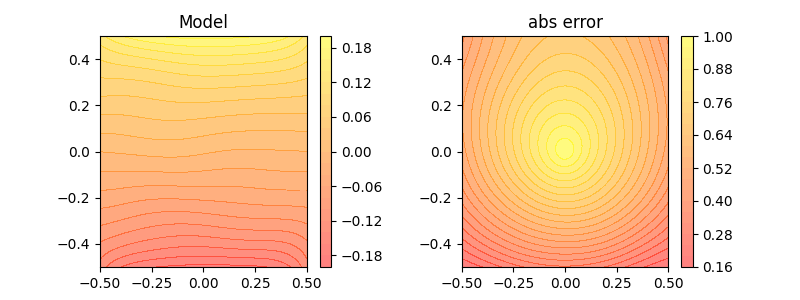

In [251]:
plot_model(vmap(phi_nn))

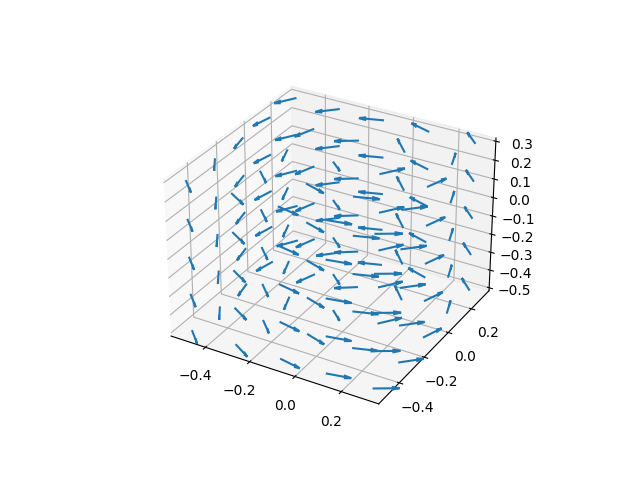

In [24]:
ax = plt.figure().add_subplot(projection='3d')

X = jnp.meshgrid(np.arange(-a/2, a/2, 0.2),
                 np.arange(-b/2, b/2, 0.2),
                 np.arange(-c/2, c/2, 0.2))

X = jnp.stack(X, axis=-1)
M = m(X)

ax.quiver(
    X[..., 0], 
    X[..., 1], 
    X[..., 2], 
    M[..., 0], 
    M[..., 1], 
    M[..., 2], 
    length=0.1)

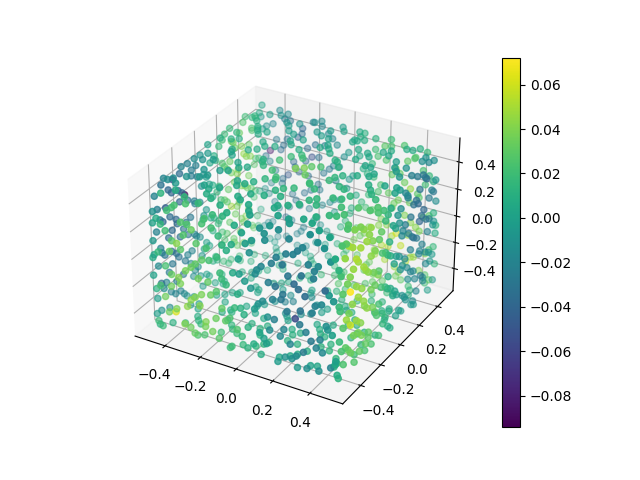

In [25]:
ax = plt.figure().add_subplot(projection='3d')

_p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=phi_bnd)
plt.colorbar(_p)
